In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import pyWENDy as WENDy
import math
import pickle
import os

In [2]:
def rhs_fun(features, params, x):
    nstates = len(x)
    x = tuple(x)
    dx = np.zeros(nstates)
    for i in range(nstates):
        dx[i] = np.sum([f(*x)*p for f, p in zip(features[i], params[i])])
    return dx


def lorenz():
    features = [
        [lambda x, y, z: y, lambda x, y, z: x],
        [lambda x, y, z: x, lambda x, y, z: x*z, lambda x, y, z: y],
        [lambda x, y, z: x*y, lambda x, y, z: z]
    ]
    params = [np.array([10, -10]), np.array([28, -1, -1]), np.array([1, -8/3])]

    x0 = np.array([-8, 10, 27])
    t =  np.linspace(0, 10, 501)
    tspan = (t[0], t[-1])
    tol_ode = 1e-15
    rhs_p = lambda t, x: rhs_fun(features, params, x)
    true_vec = np.concatenate(params).reshape(-1, 1)
    options_ode_sim = {"rtol": tol_ode, "atol": tol_ode*np.ones(len(x0))}

    t0 = time.time()
    sol = solve_ivp(rhs_p, t_span = tspan, y0=x0, t_eval=t, rtol=tol_ode, atol=tol_ode)
    #print("sim time =", time.time() - t0)
    x = sol.y.T
    t = sol.t
    #plt.plot(t, x)
    return x, t, params, x0, true_vec, features, rhs_p

def logistic_growth():
    features = [
        [lambda x: x, lambda x: x**2]
    ]
    params = [np.array([ 1, -1])]
    x0 = np.array([ 0.01 ])
    t =  np.linspace(0, 10, 501)
    tspan = (t[0], t[-1])
    tol_ode = 1e-15

    rhs_p = lambda t, x: rhs_fun(features, params, x)
    true_vec = np.concatenate(params).reshape(-1, 1)
    options_ode_sim = {"rtol": tol_ode, "atol": tol_ode*np.ones(len(x0))}

    t0 = time.time()
    sol = solve_ivp(rhs_p, t_span = tspan, y0=x0, t_eval=t, rtol=tol_ode, atol=tol_ode)
    #print("sim time =", time.time() - t0)
    x = sol.y.T
    t = sol.t
    #plt.plot(t, x)
    return x, t, params, x0, true_vec, features, rhs_p

x, t, params, x0, true_vec, features,rhs_p = logistic_growth()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


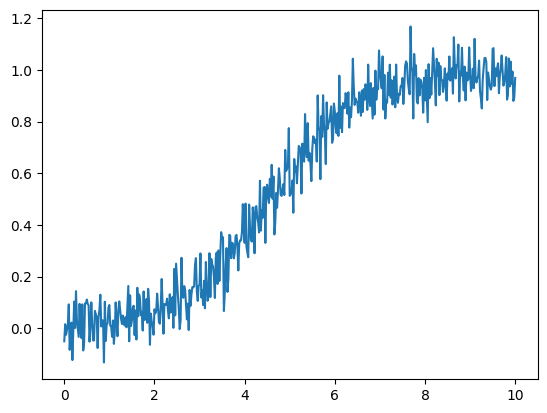

In [3]:
def gen_noise(U_exact, sigma_NR, noise_dist, noise_alg):
    if noise_alg == 0:  # additive
        stdv = np.square(np.sqrt(np.mean(np.square(U_exact))))
    elif noise_alg == 1:  # multiplicative
        stdv = 1
    dims = U_exact.shape
    if noise_dist == 0:  # white noise
        if sigma_NR > 0:
            sigma = sigma_NR * np.sqrt(stdv)
        else:
            sigma = -sigma_NR
        noise = np.random.normal(0, sigma, dims)
    elif noise_dist == 1:  # uniform noise
        if sigma_NR > 0:
            sigma = np.sqrt(3 * np.square(sigma_NR) * stdv)
        else:
            sigma = -sigma_NR
        noise = sigma * (2 * np.random.rand(*dims) - 1)
    if noise_alg == 0:  # additive
        U = U_exact + noise
    elif noise_alg == 1:  # multiplicative
        U = U_exact * (1 + noise)
    noise_ratio_obs = np.linalg.norm(U - U_exact) / np.linalg.norm(U_exact)
    return U, noise, noise_ratio_obs, sigma
#x, t, params, x0, true_vec, features, rhs_p =  utils.customODE()

subsamp =  1 # subsample data in time
tobs = t[::subsamp]
xobs = x[::subsamp, :]
M, nstates = xobs.shape

#add noise
#np.random.seed(1)
noise_ratio = 0.1
noise_dist = 0
noise_alg = 0
#rng_seed = np.random.get_state()[1][2]
#np.random.seed(rng_seed)
xobs_n, noise, _, sigma = gen_noise(xobs, noise_ratio, noise_dist, noise_alg)
plt.plot(tobs, xobs_n)

In [25]:
#IRLS - SL
start = time.time()
IRSL_SL_model = WENDy.PyWENDy(features)
w_hat = IRSL_SL_model.fit_IRLS(xobs_n, tobs, radius = None, gap = 1, type_rad=0, p = 16, S = 1, mu = [1, 2, 1], toggle_SVD=False, diag_reg=1e-10, trunc=0)
runtime = time.time() - start
u_hat = IRSL_SL_model.simulate(x0=xobs[0], t=tobs)

E_2 = np.linalg.norm(w_hat - true_vec)/np.linalg.norm(true_vec)*100
E_FS = np.linalg.norm(u_hat - xobs, 'fro')/np.linalg.norm(xobs, 'fro')*100

print('Radius:', IRSL_SL_model.radius)
print('Param error:',  f"{E_2:.3f}%")
print("FS error:", f"{E_FS:.3f}%")
print('Runtime', f"{runtime:.3f}s")

Radius: [20]
Param error: 4.132%
FS error: 2.945%
Runtime 0.323s


In [27]:
#IRLS - MG
start = time.time()
IRSL_MG_model = WENDy.PyWENDy(features)
w_hat = IRSL_MG_model.fit_IRLS(xobs_n, tobs, radius = None, gap = 1, type_rad=1, p = 16, S = 1, mu = [1, 2, 1], toggle_SVD=True, diag_reg=1e-10, trunc=0)
runtime = time.time() - start
u_hat = IRSL_MG_model.simulate(x0=xobs[0], t=tobs)

E_2 = np.linalg.norm(w_hat - true_vec)/np.linalg.norm(true_vec)*100
E_FS = np.linalg.norm(u_hat - xobs, 'fro')/np.linalg.norm(xobs, 'fro')*100

print('Radius:', IRSL_MG_model.radius)
print('Param error:',  f"{E_2:.3f}%")
print("FS error:", f"{E_FS:.3f}%")
print('Runtime', f"{runtime:.3f}s")

Radius: [ 9 18 36 72]
Param error: 5.008%
FS error: 3.723%
Runtime 1.982s


In [29]:
#OLS - SL
start = time.time()
OLS_SL_model = WENDy.PyWENDy(features)
w_hat = OLS_SL_model.fit_OLS(xobs_n, tobs, radius = None, gap = 1, type_rad=0, p = 16, S = 1, mu = [1, 2, 1], toggle_SVD=False, diag_reg=1e-10, trunc=0)
runtime = time.time() - start
u_hat = OLS_SL_model.simulate(x0=xobs[0], t=tobs)

E_2 = np.linalg.norm(w_hat - true_vec)/np.linalg.norm(true_vec)*100
E_FS = np.linalg.norm(u_hat - xobs, 'fro')/np.linalg.norm(xobs, 'fro')*100

print('Radius:', OLS_SL_model.radius)
print('Param error:',  f"{E_2:.3f}%")
print("FS error:", f"{E_FS:.3f}%")
print('Runtime', f"{runtime:.3f}s")

Radius: [20]
Param error: 4.462%
FS error: 3.771%
Runtime 0.305s


In [30]:
#OLS - MG
start = time.time()
OLS_MG_model = WENDy.PyWENDy(features)
w_hat = OLS_MG_model.fit_OLS(xobs_n, tobs, radius = None, gap = 1, type_rad=1, p = 16, S = 1, mu = [1, 2, 1], toggle_SVD=True, diag_reg=1e-10, trunc=0)
runtime = time.time() - start
u_hat = OLS_MG_model.simulate(x0=xobs[0], t=tobs)

E_2 = np.linalg.norm(w_hat - true_vec)/np.linalg.norm(true_vec)*100
E_FS = np.linalg.norm(u_hat - xobs, 'fro')/np.linalg.norm(xobs, 'fro')*100

print('Radius:', OLS_SL_model.radius)
print('Param error:',  f"{E_2:.3f}%")
print("FS error:", f"{E_FS:.3f}%")
print('Runtime', f"{runtime:.3f}s")

Radius: [20]
Param error: 4.491%
FS error: 3.096%
Runtime 2.046s
